# Homework 4

dataset - !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Data preparation

* Take a subset of columns
* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

In [3]:
df = pd.read_csv("data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
columns = ['Make', 'Model', 'Engine HP', 'Engine Cylinders', 'Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']

df = df[columns].copy()
df.head()

,Make,Model,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,230.0,6.0,MANUAL,Convertible,28,18,34500


In [6]:
df.columns = df.columns.str.lower().str.replace(" ",'_')

In [7]:
df = df.fillna(0)

In [8]:
mean_price = df['msrp'].mean()
df['above_average'] = (df.msrp >= mean_price).astype(int)

del df['msrp']

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_test['above_average']
del df_val['above_average']

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

Answer -> 'engine_hp' has the highest AUC score with 0.92

Higher AUC score means that feature is more important to include in the model

In [11]:
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = list(df.dtypes[df.dtypes == 'object'].index)

print(f"Numerical-> {numerical}")
print(f'Categorical -> {categorical}')

Numerical-> ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
Categorical -> ['make', 'model', 'transmission_type', 'vehicle_style']


In [14]:
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if  auc <0.5:
        auc = roc_auc_score(y_train, -df_train[n])

    print("%16s, %.3f" % (n,auc))

       engine_hp, 0.917
engine_cylinders, 0.766
     highway_mpg, 0.633
        city_mpg, 0.673


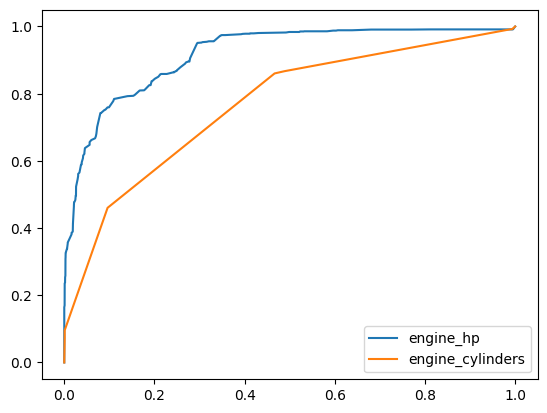

In [22]:
#engine hp
fpr, tpr, _ = roc_curve(y_train,df_train.engine_hp)
plt.plot(fpr, tpr, label = 'engine_hp')

#egnine cylinders
fpr, tpr, _ = roc_curve(y_train,df_train.engine_cylinders)
plt.plot(fpr, tpr, label = 'engine_cylinders')

plt.legend()

# Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) What's the AUC of this model on the validation dataset? (round to 3 digits)

0.678

0.779

0.878

0.979

Answer -> 0.979 approx

In [28]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

In [29]:
roc_auc_score(y_val, y_pred)

0.9813431779873112

# Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall
Plot them


At which threshold precision and recall curves intersect?

0.28
0.48
0.68
0.88

Answer - `0.48`

In [31]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [34]:
df_scores = confusion_matrix_dataframe(y_val,y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,646,348,8,1381
20,0.2,628,208,26,1521
30,0.3,607,131,47,1598
40,0.4,597,86,57,1643
50,0.5,575,64,79,1665
60,0.6,553,46,101,1683
70,0.7,514,26,140,1703
80,0.8,461,12,193,1717
90,0.9,372,3,282,1726


In [35]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,646,348,8,1381,0.649899,0.987768
20,0.2,628,208,26,1521,0.751196,0.960245
30,0.3,607,131,47,1598,0.822493,0.928135
40,0.4,597,86,57,1643,0.874085,0.912844
50,0.5,575,64,79,1665,0.899844,0.879205
60,0.6,553,46,101,1683,0.923205,0.845566
70,0.7,514,26,140,1703,0.951852,0.785933
80,0.8,461,12,193,1717,0.974630,0.704893
90,0.9,372,3,282,1726,0.992000,0.568807


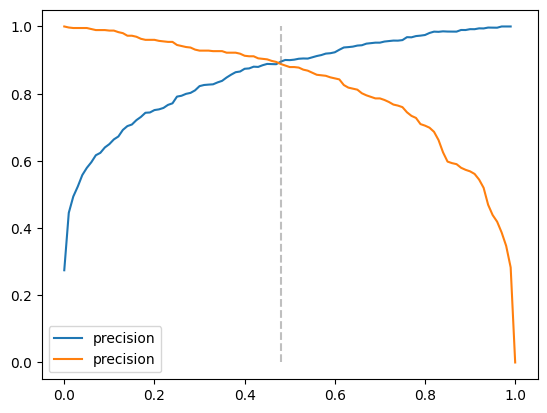

In [38]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='precision')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()